# Target

*   Achieve consistent validation accuracy of 99.4% or above.
*   Add another image augmentation( color jitter).It randomly changes the brightness, contrast and saturation of an image. Even though the images are black and white, changing contrast and brightness may help.

# Result

*   Params = 9,922
*   Best Train Accuracy = 98.36% at 14th epoch
*   Best Test Accuracy = 99.40% at 10th and 12th epoch

# Analysis

*   The model is still underfitting. But we are being a bit harsh on our model by applying augmentations.
*   Introducing `ColorJitter` helped us. Not only we got the desired validation accuracy but the results are now more consistent and the accuracy is around 99.39% in last few epochs. The model has capacity to reach much better accuracy if trained for more epochs after rectifying the slow training.


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
!pip install torchsummary

## Model

In [ ]:
dropout_value = 0.10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 26

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 24

        # transition block 
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 10

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding = 0),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8

        #
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1), 
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value),
        #     nn.ReLU()
        # )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 0), 
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6( padding = 1)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 6)
        ) # output_size = 1

        # final FC layer (read fully convolutional, not fully connected)
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=1),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        )

        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            # x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.gap(x)
            x = self.conv8(x)
            x = self.conv9(x)

            x = x.view(-1, 10)
            return F.log_softmax(x)


## Model Summary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,820
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             210
        MaxPool2d-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Data loading and transformations

In [ ]:
torch.manual_seed(1) # for consistent output
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)), 
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # mean, std of the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


## Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # setting the gradients to zero after every backprop step
    y_pred = model(data) # predicting the values
    loss = F.nll_loss(y_pred, target) # calculating the loss using negative loss likelihood
    train_losses.append(loss)
    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    accuracy = 100. * correct / processed

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.append(100. * correct / processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 15):
    print('Epoch:',  epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.3655482828617096 Batch_id=937 Accuracy=89.89: 100%|██████████| 938/938 [00:37<00:00, 24.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9827/10000 (98.27%)

Epoch: 2


Loss=0.10880998522043228 Batch_id=937 Accuracy=96.34: 100%|██████████| 938/938 [00:37<00:00, 24.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9906/10000 (99.06%)

Epoch: 3


Loss=0.021212702617049217 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:37<00:00, 24.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9898/10000 (98.98%)

Epoch: 4


Loss=0.1466040164232254 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:37<00:00, 24.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

Epoch: 5


Loss=0.048933807760477066 Batch_id=937 Accuracy=97.53: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

Epoch: 6


Loss=0.022799773141741753 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:38<00:00, 24.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

Epoch: 7


Loss=0.1905769407749176 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:37<00:00, 24.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Epoch: 8


Loss=0.17860029637813568 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:37<00:00, 24.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

Epoch: 9


Loss=0.03608456254005432 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:37<00:00, 24.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

Epoch: 10


Loss=0.012042970396578312 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:37<00:00, 24.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

Epoch: 11


Loss=0.008900598622858524 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

Epoch: 12


Loss=0.01564835011959076 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:37<00:00, 24.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

Epoch: 13


Loss=0.22732938826084137 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:37<00:00, 25.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

Epoch: 14


Loss=0.002042955020442605 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:37<00:00, 24.95it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)



## Plotting

Text(0.5, 1.0, 'Test Accuracy')

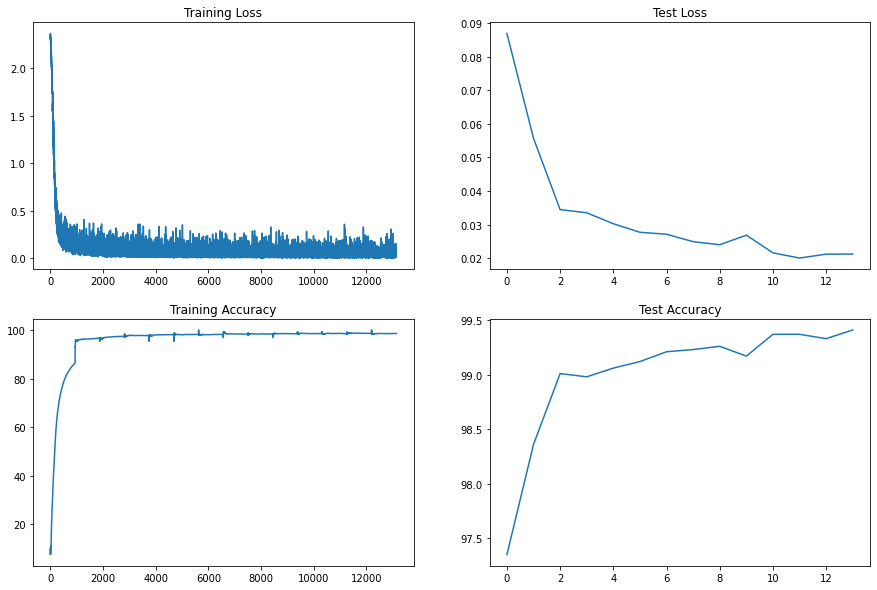

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")